In [42]:
import numpy as np
import pandas as pd
from scipy.fft import fft
from scipy.linalg import toeplitz

import matplotlib.pyplot as plt
from matplotlib import cm

plt.style.use('seaborn-white')

### 1
**(a)** By page 52 in notes, the spectual density function of an $\text{ARMA}(p, q)$ process is  given by
\begin{equation}
S_X(f) = \sigma_{\epsilon}^2\frac{G_{\theta}(f)}{G_{\phi}(f)}.
\end{equation}
where $$G_{\theta}(f)=|1-\theta_{1,q}e^{-2i\pi f}-...-\theta_{q, q}e^{-2i\pi fq}|^2, $$ $$G_{\phi}(f)=|1-\phi_{1, q}e^{-2i\pi f}-...-\phi_{q, q}e^{-2i\pi fq}|^2.$$

In [62]:
def S_ARMA(f, sigma2, phis=[], thetas=[]):
    '''
    Computes the theoretical sdf for an ARMA(p, q) process.

    param f: numpy array of frequencies at which sdf should be evaluated
    param sigma2: scalar; the variance of the white noise process
    param phis: array containing the phi parameters
    param thetas: array containing the theta parameters
    
    return: numpy array of sdf evaluated at f
    '''
    p, q = len(phis), len(thetas)
    xis_t = np.exp(-1j*2*np.pi*np.outer(f, np.arange(1, q+1)))
    xis_p = np.exp(-1j*2*np.pi*np.outer(f, np.arange(1, p+1)))
    G_t = 1 - (thetas * xis_t).sum(1)  # G_theta
    G_p = 1 - (phis * xis_p).sum(1)    # G_phi
    return (sigma2 * np.abs(G_t)**2 / np.abs(G_p)**2)

**(b)** The following code implements the burn in method to generate an $\text{ARMA}(2,2)$ process of length $N$: 
1. Set $X_1=X_2=0$ 
2. For $i=3$ to $100+N$, set $X_i \gets \phi_{1,2} X_{i-1}+\phi_{2,2}X_{i-2}+\epsilon_i-\theta_{1, 2}\epsilon_{i-1}-\theta_{2,2}\epsilon_{i-2}$
3. Return $X_{101},...,X_{101+N}$.

In [45]:
def ARMA22_sim(phis, thetas, sigma2, N):
    """
    Simulates a Gaussian ARMA(2,2) process. 

    param phis: numpy array containing the phi parameters
    param thetas: numpy array containing the theta parameters
    param sigma2: scalar; variance of the white noise process
    N: scalar; length of the simulated process

    return: numpy array of size N; realiasation of an ARMA(2,2) process
    """
    eps = np.random.normal(size=100+N, scale=np.sqrt(sigma2))    # simulate white noice process
    X = np.zeros(100 + N)

    for i in range(2, 100+N):
        X[i] = phis[0]*X[i-1] + phis[1]*X[i-2] + eps[i] \
            - (thetas[0]*eps[i-1] + thetas[1]*eps[i-2])
    
    return X[-N:]

**(c)**
By page 58 in notes, the periodogram for a time series $X$ is given by
\begin{equation*}
\hat{S}^{(p)}(f) = \frac{1}{N}\left|\sum_{i=1}^NX_te^{-i2\pi ft}\right|^2.
\end{equation*}

In [64]:
def periodogram(X):
    """Computes the periodogram at the Fourier frequencies for a time series X."""
    N = X.shape[-1]
    S = fft(X)   # computes the sum inside the norm
    return np.abs(S)**2 / N

By page 62 in notes, the spectual density of a $p\times 100\%$ cosine tapered estimato is given by 
\begin{equation*}
\hat{S}^{(d)}(f) = \left|\sum_{i=1}^Nh_tX_te^{-i2\pi ft}\right|^2, 
\end{equation*}
where the consine taper sequence $h_t$ is as defined on page 64.

In [ ]:
def tapered_series(X, taper):
    """Computes the series ht*Xt for p*100% cosine tapered spectual estimates."""
    N = X.shape[-1]

    # Construct the H_t sequence
    H = np.ones(N,)
    tt = np.floor(taper*N)
    H[:int(tt//2)] = (1 - np.cos(2*np.pi*np.arange(tt//2) / (tt+1))) / 2
    H[N-int(tt//2):] = (1 - np.cos(
        2*np.pi*(N+1-np.arange(N-int(tt//2), N)) / (tt+1))
    ) / 2
    H /= np.sqrt((H**2).sum())    # normalise
    
    return H * X

def direct(X, p):
    """
    Computes the direct spectral estimate at the Fourier frequencies using the \
    p*100% cosine taper for a time series X.
    """
    hX = tapered_series(X, p)
    return np.abs(fft(hX))**2

**(d)**

*(A)* 
By page 30 in notes, an ARMA(2,2) process is stationary if all the roots of $$\Phi(z)=1-\phi_{1,2}z-\phi_{2,2}z^2$$ lie outside the unit circle. Using the representation of roots $z_1=\frac{1}{r}e^{-i2\pi f'}$ and $z_2=\frac{1}{r}e^{i2\pi f'}$, by similar arguments in page 51, we have that 
$$\phi_{1,2}=2r\cos(2\pi f'),\qquad\phi_{2,2}=-r^2.$$

In [69]:
r = 0.8
N = 128
fp = 12/128
phis = np.array([2*r*np.cos(2*np.pi*fp), -r**2])
thetas = np.array([-0.5, -0.2])

# Simulate 10000 ARMA(2,2) realisation
np.random.seed(7)
X = np.array([ARMA22_sim(phis, thetas, 1, N) for _ in range(10000)])

`per_single`, `dse_p1_single`, `dse_p2_single`, `dse_p3_single` and `dse_p4_single` store the spectual estimates at $f=12/128, 32/128, 60/128$ based on the periodogram, 5%, 10%, 25% and 50% cosine tapers respectively.

In [70]:
per_single = periodogram(X).T[[12, 32, 60]]    # periodograms

# cosine tapers
ps = [0.05, 0.1, 0.25, 0.5]
dse_p1_single = direct(X, 0.05).T[[12, 32, 60]]
dse_p2_single = direct(X, 0.1).T[[12, 32, 60]]
dse_p3_single = direct(X, 0.25).T[[12, 32, 60]]
dse_p4_single = direct(X, 0.5).T[[12, 32, 60]]

*(B)* The sample bias of a sequence of estimates $\hat{s}_1, \hat{s}_2, ..., \hat{s}_N$ at frequancy $f$ is given by $$\frac{1}{N}\sum_{i=1}^N\hat{s}_i - s$$
where $s$ is the true spectual density at frequancy $f$.

In [73]:
fs = np.array([12/128, 32/128, 60/128])

estimates = np.dstack([per_single, dse_p1_single, dse_p2_single, dse_p3_single, dse_p4_single])
true_sdf = S_ARMA(fs, sigma2=1, phis=phis, thetas=thetas)
sample_bias_vals = estimates.mean(1).T - true_sdf

# Sample bias table for each estimator when r=0.8
sample_bias = pd.DataFrame(sample_bias_vals, columns=['f=' + str(int(f*128)) + '/128' for f in fs])
sample_bias.rename_axis(columns='freq', inplace=True)
sample_bias.set_axis(['periodogram'] + [f'{int(p*100)}% cosine taper'  for p in ps], axis='index', inplace=True)
print('Sample bias of different spectual density estimators (r=0.8):')
sample_bias

Sample bias of different spectual density estimators (r=0.8):


freq,f=12/128,f=32/128,f=60/128
periodogram,-2.561065,0.129317,0.051919
5% cosine taper,-2.318748,0.068238,0.005019
10% cosine taper,-2.041909,0.018517,0.000321
25% cosine taper,-1.721829,-0.004065,0.000002
50% cosine taper,-1.513529,-0.007609,0.000101


*(C)*

In [76]:
### This block may take 1-2 mins to run

N = 128
fp = 12/128
thetas = [-0.5, -0.2]    # unchanged

rs = np.arange(0.8, 1.0, 0.01)
phis = np.array([2*rs*np.cos(2*np.pi*fp), -rs**2]).T   # 20x2 array, recording phi values for each r

# sample 10000 realisations for each sets of phi
np.random.seed(7)
XX = np.array([[ARMA22_sim(phi, thetas, 1, N) for _ in range(10000)] for phi in phis])    # shape=(20, 10000, 128)


# Compute the spectual density estimates using the same 5 estimators as above
perXX = periodogram(XX)[..., [12, 32, 60]]    # shape=(20, 10000, 3)
dse_p1 = direct(XX, 0.05)[..., [12, 32, 60]]
dse_p2 = direct(XX, 0.1)[..., [12, 32, 60]]
dse_p3 = direct(XX, 0.25)[..., [12, 32, 60]]
dse_p4 = direct(XX, 0.5)[..., [12, 32, 60]]


# Compute the true spectual density
true_sdf = np.array([S_ARMA(
    fs, sigma2=1, phis=phi, thetas=thetas
) for phi in phis])  #  20x3 array

# Compute the sample bias
sample_mean = np.stack((perXX, dse_p1, dse_p2, dse_p3, dse_p4)).mean(2)
sample_bias = sample_mean - true_sdf    # shape=(5, 20, 3)

*(D)*

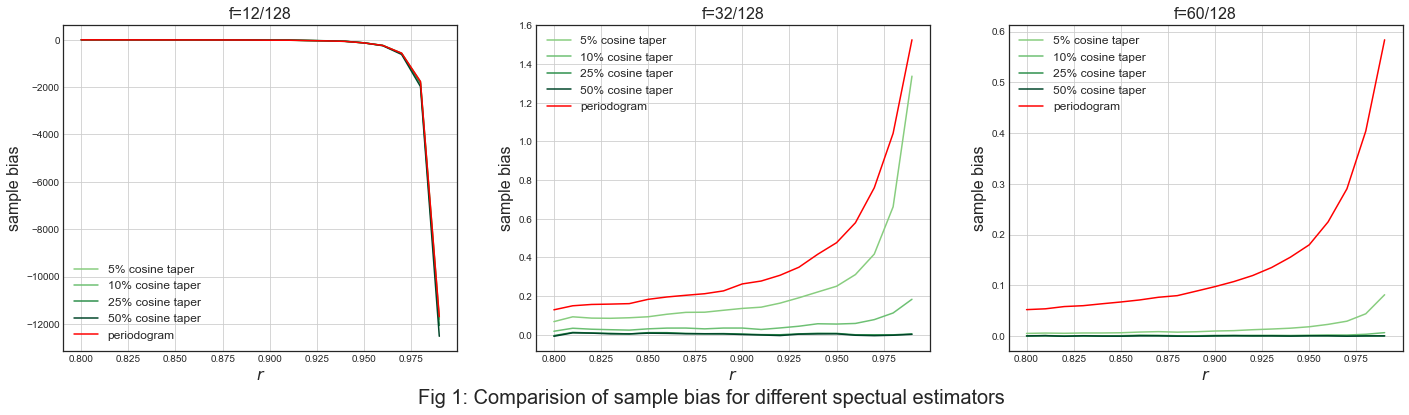

In [113]:
fig = plt.figure(figsize=(24, 6))

for i in range(3):
    plt.subplot(1, 3, i+1)
    for ip in range(4):
        plt.plot(rs, sample_bias[ip+1, :, i], c=cm.YlGn(1.25*ps[ip]+0.4), label=f'{int(ps[ip]*100)}% cosine taper')
    plt.plot(rs, sample_bias[0, :, i], 'r-', label='periodogram')
    plt.xlabel(r'$r$', fontsize=16)
    plt.ylabel('sample bias', fontsize=16)
    plt.title(f'f={int(fs[i]*128)}/128', fontsize=16)
    plt.grid()
    plt.legend(fontsize=12)
# fig.suptitle('Comparision of sample bias for different spectual estimators', fontsize=20)
txt = '\n\nFig 1: Comparision of sample bias for different spectual estimators'
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=20)
plt.show()

*(e)*
- As shown in Figure 1, at the oscillating frequency $f=12/128$, spectual density is underestimated by all five estimators, while at the two frequencies away from the oscillating frequency, spectual density is overestimated. This suggests the existence of sidelobe leakage. 
- From the two Figure 2 and 4 below, one can see that for larger $r$ the process has larger dynamic range. As a result, for each estimator there are more sidelobe leakage as $r$ gets close to 1, resulting in significantly larger (absolute) sample bias, as shown in Figure 1.
- At the oscillating frequency $f=12/128$, the periodogram and the tapered estimators have similar sample bias. 
- At the two frequencies away from the oscillating frequency, the tapered estimators have smaller bias than periodogram. In particular, more tapering (larger $p$) results in larger bias reduction. 
- At $f=32/128$, the $25\%$ and $50\%$ taperered estimators have almost zero bias. At $f=60/128$ (even further away from the oscillating frequency), all four cosine tapered estimates have very low bias for $r$ that is not extremely close to 1. 

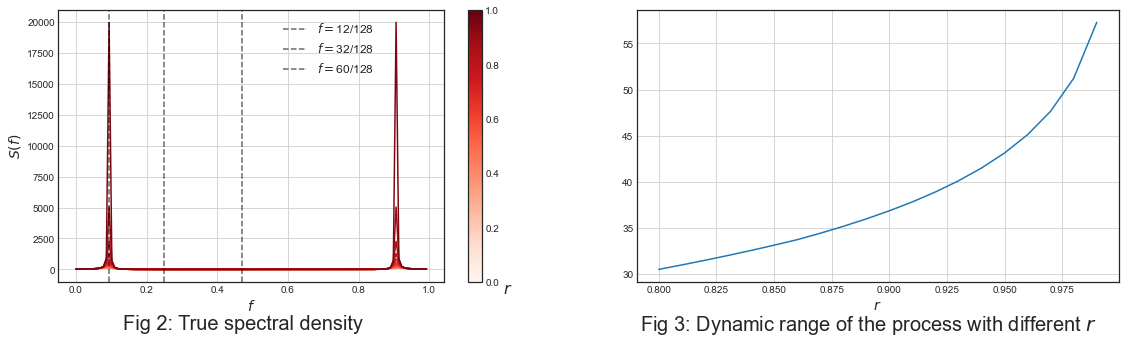

In [117]:
## True sdf
fss = np.arange(128) / 128
sdf = np.array([S_ARMA(fss, sigma2=1, phis=phi, thetas=thetas) for phi in phis])

plt.figure(figsize=(19, 5))
plt.subplot(121)
for k in range(20):
    plt.plot(fss, sdf[k], c=cm.Reds(k/20), lw=1.5)
sm = plt.cm.ScalarMappable(cmap=cm.Reds)

for f in fs:
    plt.axvline(x=f, alpha=0.6, c='k', linestyle='--', label=r'$f=$'+f'{int(f*128)}/128')
cbar = plt.colorbar(sm)
cbar.set_label(r'$r$', rotation=0, fontsize=16, loc='bottom')

plt.xlabel(r'$f$', fontsize=14)
plt.ylabel(r'$S(f)$', fontsize=14)
plt.figtext(0.26, 0.001, '\nFig 2: True spectral density', wrap=True, horizontalalignment='center', fontsize=20)
# plt.title('True spectral density', fontsize=16)
plt.legend(loc=9, bbox_to_anchor=(0.7, 1), fontsize=12)
plt.grid()


## Dynamic range
plt.subplot(122)
dynamic_range = 10 * np.log10(sdf.max(-1) / sdf.min(-1))
plt.plot(rs, dynamic_range)
# plt.title(r'Dynamic range of the process with different $r$', fontsize=14)
plt.figtext(0.55, 0.001, '\nFig 3: Dynamic range of the process with different $r$', wrap=True, fontsize=20)
plt.xlabel(r'$r$', fontsize=14)
plt.grid()
plt.show()


## 2

### (a)

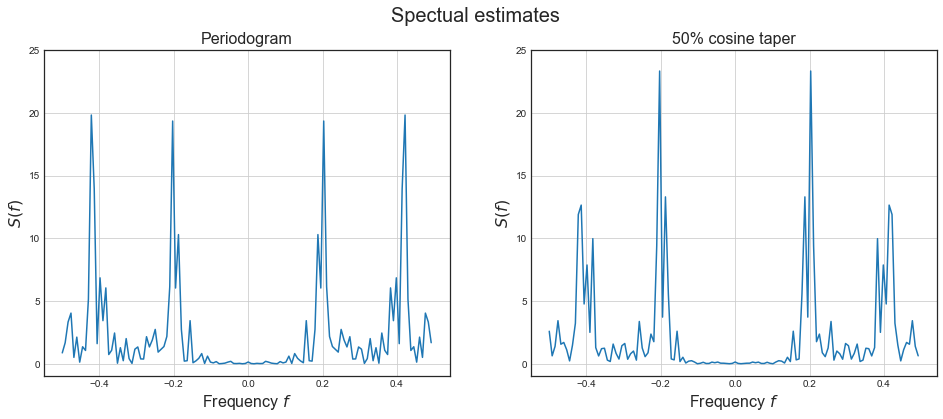

In [114]:
X2 = np.genfromtxt('154.csv', delimiter=',')
N = X2.shape[-1]

per = np.fft.fftshift(periodogram(X2)) 
dse = np.fft.fftshift(direct(X2, 0.5))
titles = ['Periodogram', '50% cosine taper']

fig = plt.figure(figsize=(16, 6))
for i, est in enumerate([per, dse]):
    plt.subplot(1, 2, i+1)
    plt.plot(np.arange(-1/2, 1/2, 1/128), est)
    plt.xlabel(r'Frequency $f$', fontsize=16)
    plt.ylabel(r'$S(f)$', fontsize=16)
    plt.title(titles[i], fontsize=16)
    plt.ylim(-1, 25)
    plt.grid()
fig.suptitle('Spectual estimates', fontsize=20)
plt.show()


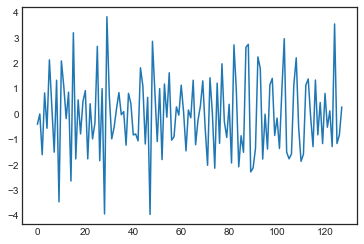

In [116]:
plt.plot(X2)

### (b)

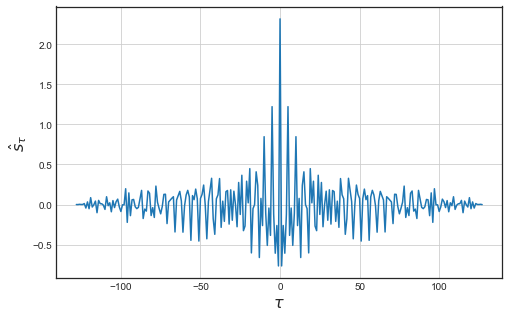

In [55]:
N = 128
def autocov_seq_hat(X, symmetry=False):
    """Compute the sample autocovariance for a time series."""
    N = X.shape[-1]
    taus = np.arange(-N, N) if symmetry else np.arange(N+1)
    Ts = np.abs(taus).astype(int)
    return np.array([(X[:N-T]*X[T:]).sum() / N for T in Ts])

stau_hat = autocov_seq_hat(X2, True)
plt.figure(figsize=(8, 5))
plt.plot(range(-N, N), stau_hat)
plt.ylabel(r'$\hat{s}_{\tau}$', fontsize=16)
plt.xlabel(r'$\tau$', fontsize=16)
plt.grid()
plt.show()


### Yule-Walker (untapered)
def estimators_YW(X, p):
    stau_hat = autocov_seq_hat(X)
    Ghat = toeplitz(stau_hat[:p])
    gamma_hat = stau_hat[1:p+1]
    phip_hat = np.linalg.inv(Ghat).dot(gamma_hat)
    sigma2_hat = stau_hat[0] - phip_hat.dot(stau_hat[1:p+1])
    return phip_hat, sigma2_hat

### Yule-Walker with 50% cosine taper

def estimators_YW_tapered(X, p, taper=0.5):
    hX = tapered_series(X, taper)
    N = hX.shape[-1]
    stau_hat = autocov_seq_hat(hX) * N
    Ghat = toeplitz(stau_hat[:p])
    gamma_hat = stau_hat[1:p+1]
    phip_hat = np.linalg.inv(Ghat).dot(gamma_hat)
    sigma2_hat = stau_hat[0] - phip_hat.dot(stau_hat[1:p+1])
    return phip_hat, sigma2_hat

### Approximate MLE

def estimators_MLE(X, p):
    F = toeplitz(X[p-1:N-1], X[p::-1])
    XX = X[p:]
    phat = np.linalg.inv(F.T @ F) @ F.T @ XX
    A = XX - F.dot(phat)
    sigma2_hat = A.T @ A / (N-2*p)
    return phat, sigma2_hat



### (c)

In [56]:
def reduced_AIC(X, p, method='YW'):
    fmap = {
        'YW': estimators_YW,
        'YW taper': estimators_YW_tapered,
        'MLE': estimators_MLE,
    }
    N = X.shape[-1]
    s2 = fmap[method](X, p)[-1]
    return 2*p + N * np.log(s2)

In [57]:
methods = ['YW', 'YW taper', 'MLE']
YW_data = np.array([reduced_AIC(X2, pp) for pp in range(1, 21)])
YW_taper_data = np.array([reduced_AIC(X2, pp, 'YW taper') for pp in range(1, 21)])
MLE_data = np.array([reduced_AIC(X2, pp, 'MLE') for pp in range(1, 21)])

df = pd.DataFrame(
    {'YW':YW_data, 'YW taper':YW_taper_data, 'MLE':MLE_data}, 
).rename_axis('p').rename(lambda x: x+1, axis='index')
df

,YW,YW taper,MLE
p,,,
1,94.783802,101.207951,88.484364
2,88.539991,91.802297,60.189262
3,58.736744,57.057308,4.743230
4,1.434667,-13.417359,10.099120
5,3.402804,-11.420202,4.460794
6,3.883213,-10.309071,27.430608
7,5.722645,-8.343541,15.235844
8,7.525434,-7.086085,28.619181
9,7.697199,-5.566404,17.343578


### (d)

In [58]:
def best_p(ps, AICs):
    return ps[np.argmin(AICs, -1)]

ps = np.arange(1, 21)
best_ps = best_p(ps, [YW_data, YW_taper_data, MLE_data])
for i in range(3):
    print(f'Best choice of p based on {methods[i]} method = {best_ps[i]}')

YW_coeffs = estimators_YW(X2, best_ps[0])
YW_taper_coeffs = estimators_YW_tapered(X2, best_ps[1])
MLE_coeffs = estimators_MLE(X2, best_ps[2])


Best choice of p based on YW method = 4
Best choice of p based on YW taper method = 4
Best choice of p based on MLE method = 5


In [59]:
print(f'Yule-Walker: Phi = {YW_coeffs[0]}, sigma^2 = {YW_coeffs[1]}')
print(f'Yule-Walker with 50% taper: Phi = {YW_taper_coeffs[0]}, sigma^2 = {YW_taper_coeffs[1]}')
print(f'Approximate MLE: Phi = {MLE_coeffs[0]}, sigma^2 = {MLE_coeffs[1]}')

Yule-Walker: Phi = [-0.81623113 -0.71385968 -0.79215113 -0.60892904], sigma^2 = 0.9500015475954233
Yule-Walker with 50% taper: Phi = [-0.82177909 -0.7716625  -0.82390842 -0.65751518], sigma^2 = 0.8459262307072268
Approximate MLE: Phi = [-0.86022111 -0.83303276 -0.91245236 -0.73306553 -0.10968231 -0.0919776 ], sigma^2 = 0.9576479573226758


### (e)

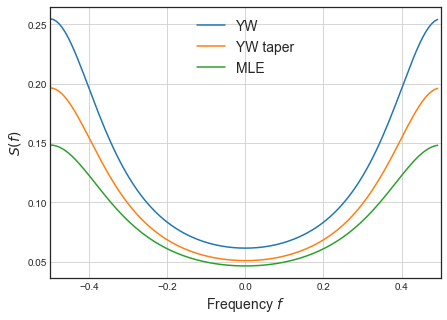

In [60]:
plt.figure(figsize=(7, 5))
for i, data in enumerate([YW_coeffs, YW_taper_coeffs, MLE_coeffs]):
    plt.plot(
        np.arange(-1/2, 1/2, 1/128), 
        S_ARMA(f=np.arange(-1/2, 1/2, 1/128), sigma2=data[-1], phis=data[:-1]), label=methods[i]
    )
plt.xlabel(r'Frequency $f$',  fontsize=14)
plt.ylabel(r'$S(f)$',fontsize=14)
plt.legend(fontsize=14)
plt.xlim(-1/2, 1/2)
# plt.ylim(0, 0.3)
plt.grid()
plt.show()

, the ARMA process can be written as
$$X_t-2r\cos(2\pi f')X_{t-1}+r^2X_{t-2}=\epsilon_t-\theta_{1, 2}\epsilon_{t-1}-\theta_{2, 2}\epsilon_{t-2}. $$

We also have that
$$S_X(f)=\sigma_{\epsilon}^2\frac{|1-\theta_{1, 2}e^{-2\pi f}-\theta_{2, 2}e^{-2\pi f}|^2}{|1-\phi_{1, 2}e^{-2\pi f}-\phi_{2, 2}e^{-2\pi f}|^2}$$
and
$$|1-\phi_{1, 2}e^{-2\pi f}-\phi_{2, 2}e^{-2\pi f}|^2=(1-2r\cos(2\pi(f'+f))+r^2)(1-2r\cos(2\pi(f'-f))+r^2)$$